# Evaluating Logistic Regression Predictions

In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

#### In this workbook we will be attempting to learn a model of  `conspiracy spreading tweets` for the day of Januray 6th in the US. The model's job is topreemptively identify whether the tweet is likely to be fake-news sharing, without delving into the content of the tweet, but rather using a series of general features. 

In [12]:
# Load the dataset
df = pd.read_stata('NSDUH_2022.dta')

### Part a): Data Cleaning & Exploration

#### Your task is to clean the data. You need to complete the following tasks: 

In [16]:
# Keep only people who ever smoked a cigarette
df = df[df['cigever'] == '1 - Yes']

# Prepare variables
# Age
def age_sort(x):
    if x == '1 - 12-17 Years Old':
        return 1
    elif x == '2 - 18-25 Years Old':
        return 2
    elif x == '3 - 26-34 Years Old':
        return 3
    elif x == '4 - 35-49 Years Old':
        return 4
    elif x == '5 - 50-64 Years Old':
        return 5
    elif x == '4 - 65 or Older':
        return 6
    else:
        return 0
    
age = df['CATAG3'].apply(age_sort)
# print(age.value_counts())

# Military service
def military_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
    
military = df['service'].apply(military_sort)
# print(military.value_counts())

# Health
def health_sort(x):
    if x == '1 - Excellent':
        return 4
    elif x == '2 - Very Good':
        return 3
    elif x == '3 - Good':
        return 2
    elif x == '4 - Fair/Poor':
        return 1
    else:
        return 0
    
health = df['HEALTH2'].apply(health_sort)
# print(health.value_counts())

# Gender
def gender_sort(x):
    if x == '1 - Male':
        return 1
    elif x == '2 - Female':
        return 0
    
gender = df['irsex'].apply(gender_sort)
# print(gender.value_counts())

# Income
def income_sort(x):
    if x == '1 - Less than $10,000':
        return 1
    elif x == '2 - $10,000 - $19,999':
        return 2
    elif x == '3 - $20,000 - $29,999':
        return 3
    elif x == '4 - $30,000 - $39,999':
        return 4
    elif x == '5 - $40,000 - $49,999':
        return 5
    elif x == '6 - $50,000 - $74,999':
        return 6
    elif x == '7 - $75,000 or more':
        return 7
    else:
        return 0
income = df['IRPINC3'].apply(income_sort)
# print(income.value_counts())

# Employment
def employment_sort(x):
    if x == '1 - Yes':
        return 1
    elif x == '2 - No':
        return 0
    else:
        return 0
employment = df['wrkdpstwk'].apply(employment_sort)
# print(employment.value_counts())

vaper = df['nicvapever'].apply(lambda x: 1 if x == '1 - Yes' else 0)
# Create design matrix 
variables = pd.DataFrame({
    'Age': age,
    'Military': military,
    'Health' : health,
    'Gender' : gender,
    'Income' : income,
    'Employment' : employment,
    'Vaper' : vaper
})

variables = variables.dropna()

X = variables[['Age', 'Military', 'Health', 'Gender', 'Income', 'Employment']].astype(int)
Y= variables['Vaper'].astype(int)

X_with_intercept = sm.add_constant(X)

#### Calculate the correlation matrix across the outcome and X. 

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


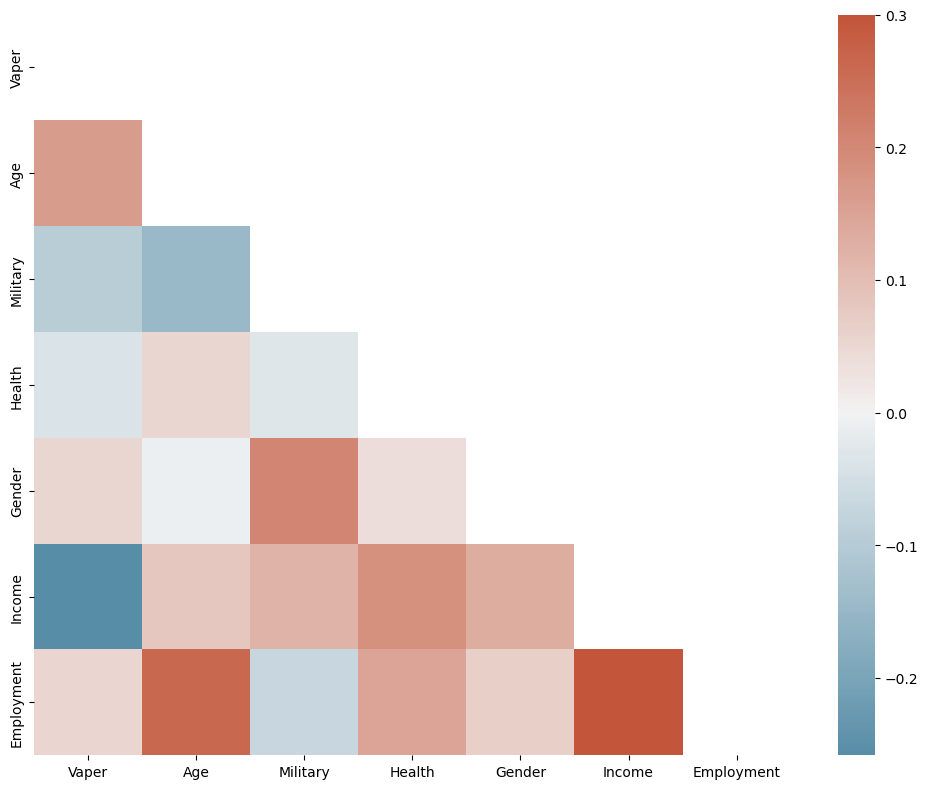

In [19]:
YX = pd.concat([Y, X], axis=1)

# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

### Part b): Model Assessment and Selection

#### i. Set up the full design matrix X, this time include the states_matrix, and a constant. 
#### Finally bind the outcome to it and ensure it's the first column of the resulting dataframe. 

In [20]:
# Design matrix
X = X

# Add a constant to the feature matrix for statsmodels
X_const = X_with_intercept

# Get full dataset together 
YX_const = pd.concat([Y, X_with_intercept], axis=1)

#### ii. Create a validation set (75%) and test set (25%). 
#### Ensure the rows of the full dataset selected for each set are chosen at random. 

In [21]:
# Split data into validation and test (75:25)

# Calculate 25% of the dataset size
num_samples = YX_const.shape[0]* 25 // 100 # Using integer division to get an integer result

# Generate a list of all row IDs
# Assuming row IDs start at 0 and go up to dataset_size-1
row_ids = list(range(YX_const.shape[0]))

# Randomly select 25% of the row IDs
selected_row_ids = random.sample(row_ids, num_samples)

# Subset to create validation and test
YX_const_test = YX_const.iloc[YX_const.index.isin(selected_row_ids)] # the randomly chosen 25% goes to test-set
YX_const_val = YX_const.iloc[~YX_const.index.isin(selected_row_ids)] # the remaining 75% is our validation set

#### iii. Using a dictionary, define three candidate models in terms of the columns of the design matrix involved in each. 
#### The first model should be the homogeneous probability model; the second should have have all covariates except the states; the third should use all the columns. 


In [22]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': ['Age', 'Health', 'Gender', 'Income', 'Employment'],
    'c': X_const.columns.tolist()
}

#### iv. Pick a metric (or more) on which you want to compare these models. Using cross-validation on the validation set, compare the models and select one you wish to deploy. 

In [24]:
y = YX_const_val['Vaper'] # Target variable

# Define K
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_const_val):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_const_val.iloc[train_index][cols], YX_const_val.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    print(average_brier_score)
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                17844
Model:                          Logit   Df Residuals:                    17843
Method:                           MLE   Df Model:                            0
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:               1.816e-11
Time:                        02:55:56   Log-Likelihood:                -12366.
converged:                       True   LL-Null:                       -12366.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0352      0.015     -2.351      0.019      -0.065      -0.006
                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observat

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.24996,0.50724,0.50000,24735.21469
1,b,0.21929,0.64761,0.64771,22421.94248
2,c,0.21860,0.66048,0.66062,22370.17915


#### v. Re-fit the selected model to the full validation set. 

In [25]:
# Pick model B, in virtue of lower AIC 
# Now fit the model to the full validation set
model = sm.Logit(YX_const_val['Vaper'], YX_const_val[predictors['c']]).fit()

Optimization terminated successfully.
         Current function value: 0.626487
         Iterations 5


In [26]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                  Vaper   No. Observations:                22305
Model:                          Logit   Df Residuals:                    22298
Method:                           MLE   Df Model:                            6
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:                 0.09603
Time:                        03:01:05   Log-Likelihood:                -13974.
converged:                       True   LL-Null:                       -15458.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2446      0.049      5.014      0.000       0.149       0.340
Age            0.2233      0.010     22.554      0.000       0.204       0.243
Military      -0.4159      0.060     -6.946      0.0

### Part c): Model Evaluation and Estimation of Generalisation Error

#### i. Generate 1000 simulations of the regression coefficients by sampling from the empirical posterior distribution. 

In [27]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### ii.  For each simulation, generate a predicted probability for the test-set conspiracy assessments. 

In [29]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_const_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_const_test[predictors['c']], beta_simulation)
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

In [30]:
predictions

array([[0.43886, 0.44226, 0.58318, ..., 0.63923, 0.71638, 0.45232],
       [0.42782, 0.44131, 0.57572, ..., 0.63461, 0.7252 , 0.44736],
       [0.43049, 0.4561 , 0.58001, ..., 0.62507, 0.71861, 0.44713],
       ...,
       [0.4265 , 0.44342, 0.58368, ..., 0.63827, 0.71543, 0.45518],
       [0.42082, 0.45648, 0.57727, ..., 0.62845, 0.71414, 0.43908],
       [0.42764, 0.46619, 0.58435, ..., 0.62282, 0.71577, 0.437  ]])

#### iii.  For the first 20 assessments in the test-set, plot the posterior distirbution of the probabilities.
#### Highlight whether the density of each lies above or below a given `threshold` for classification. 

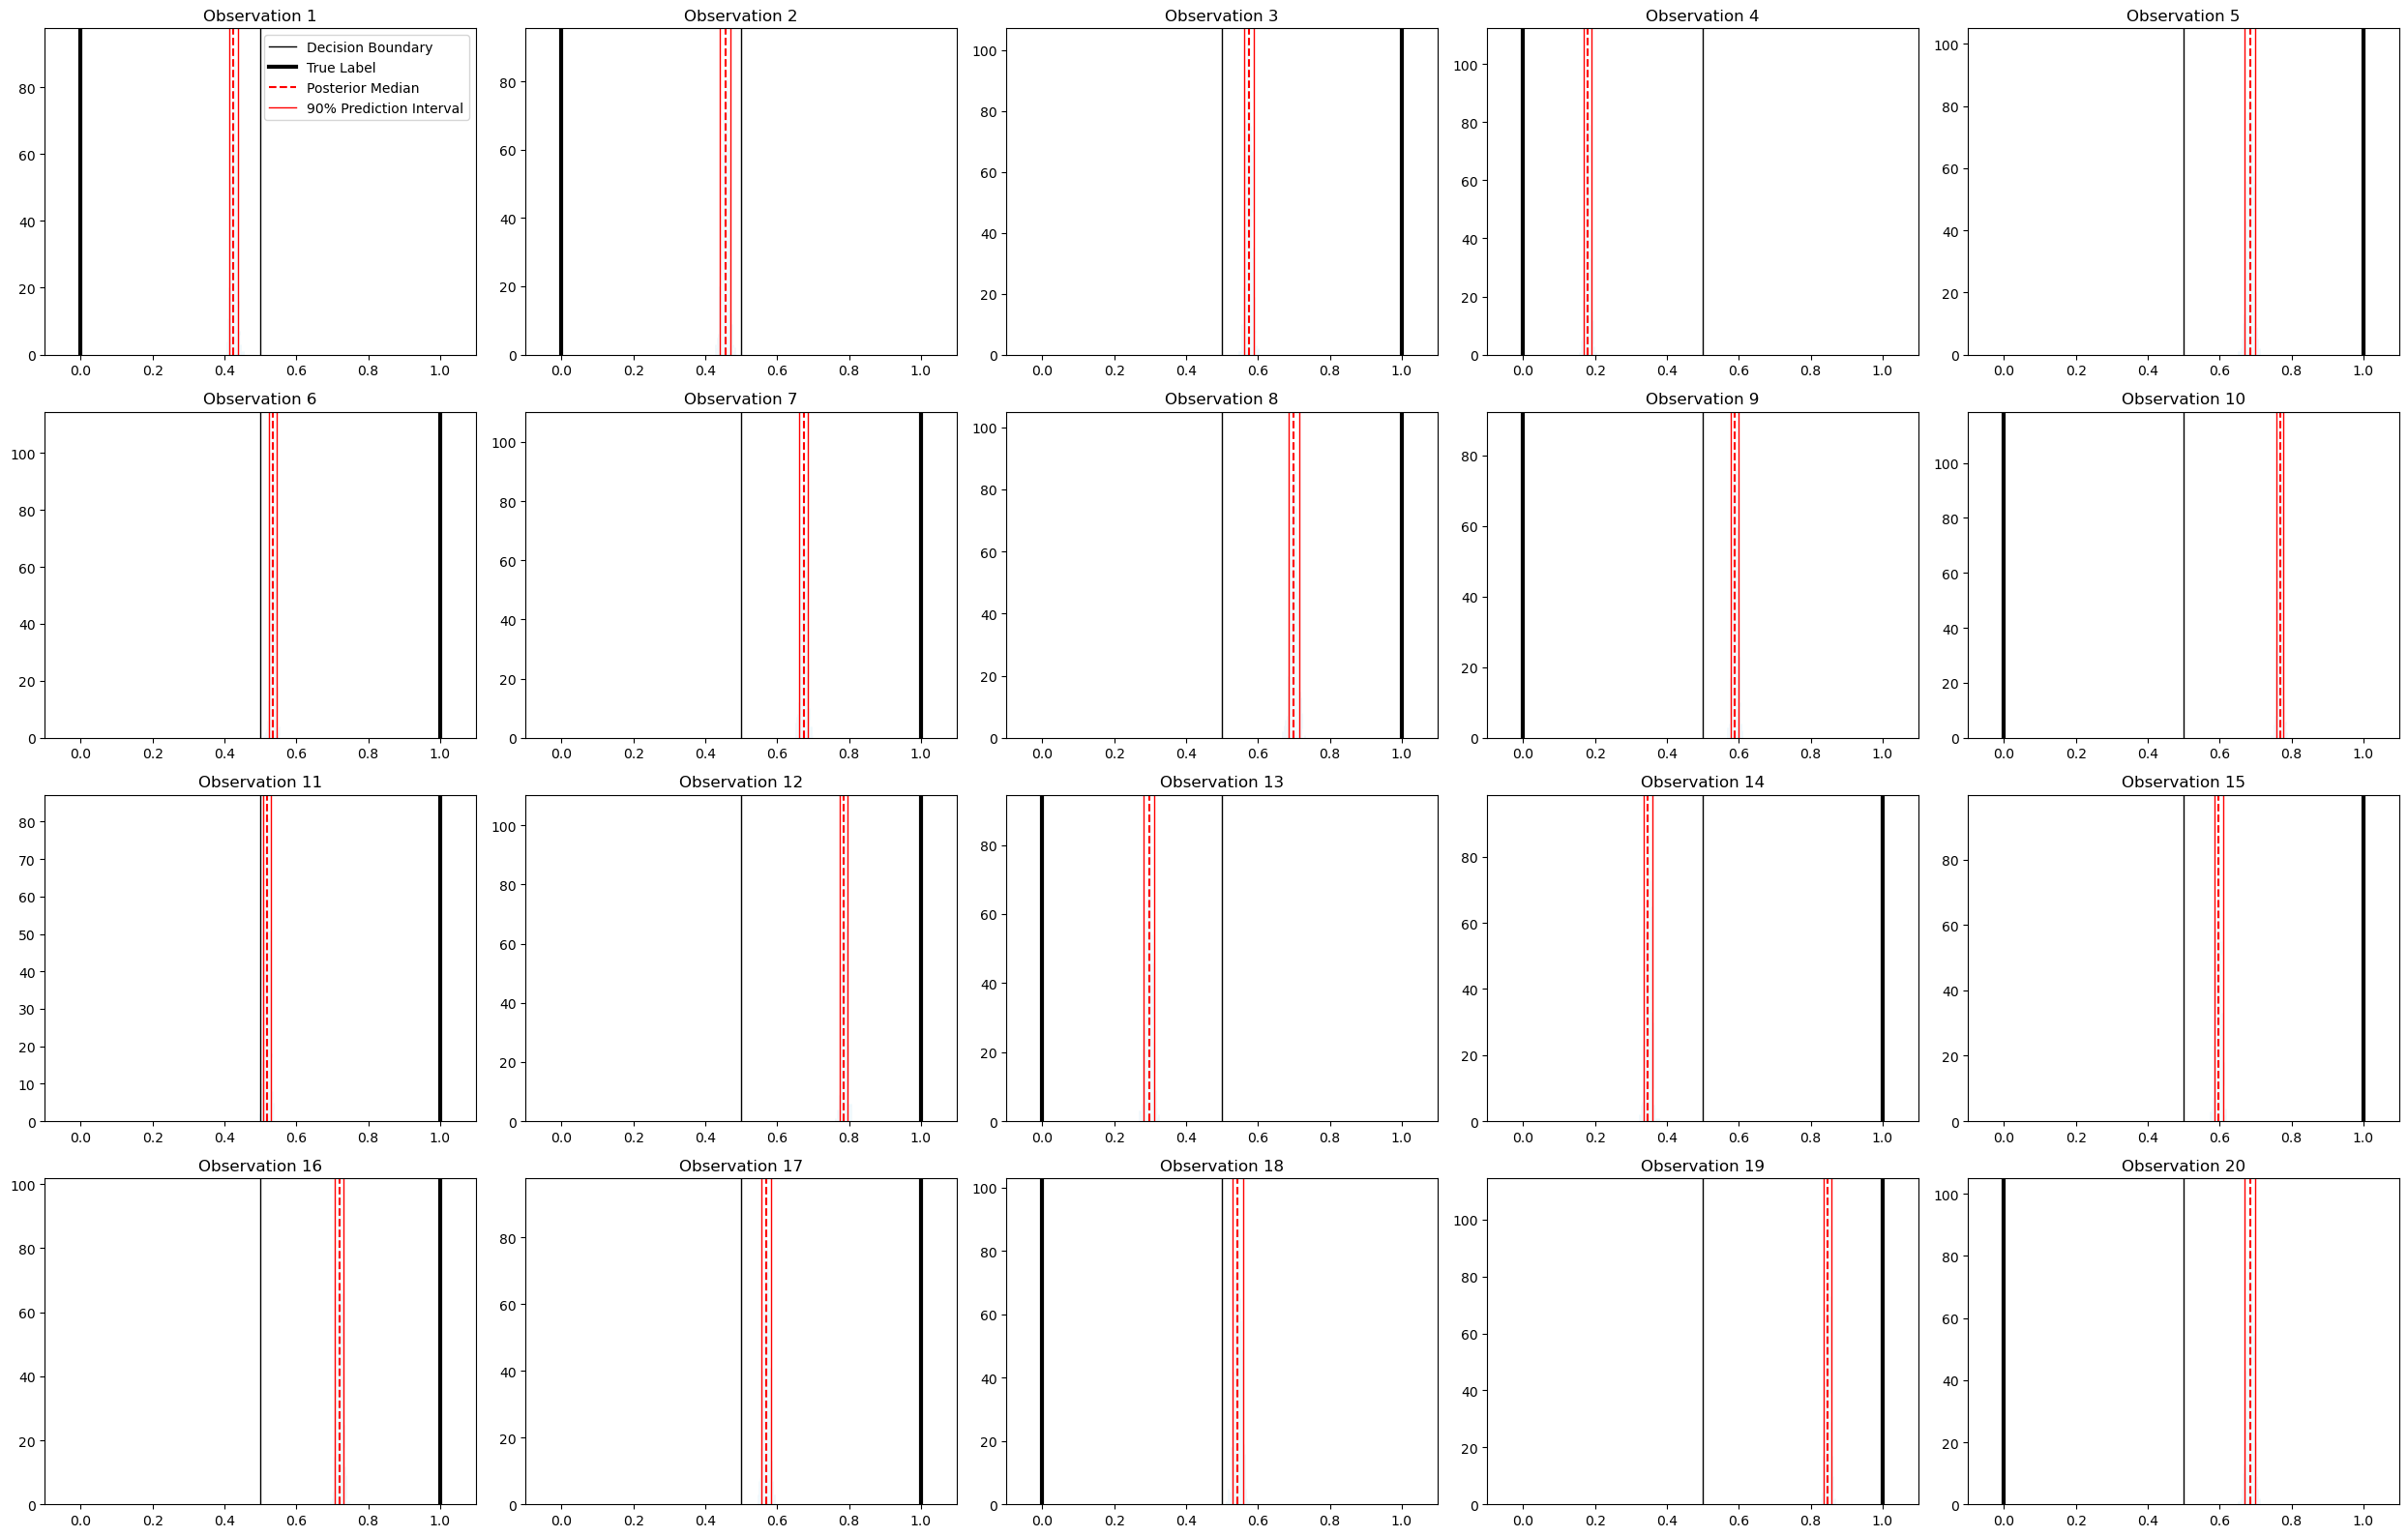

In [31]:
true_labels = YX_const_test['Vaper']

# Calculate posterior median and the 90% prediction interval for each of the first 10 observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

#### v. Simulate classes (1s or 0s) for the test-set conspiracy assessments, from the posterior predictive distirbution. 

In [32]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

#### vi. Calculate the generalisation error for Classification. 
#### You can choose any classification error metric you wish (i.e. any metric from the confusion matrix). The most basic metric we might be interested about is just `accuracy`. 

#### Hint: We have 1000 simulated predicted classes. For each of those 1000 sets of simulations of the test-set labels, you need to calculate the accuracy. Then you have to plot the histogram of the accuracies. 

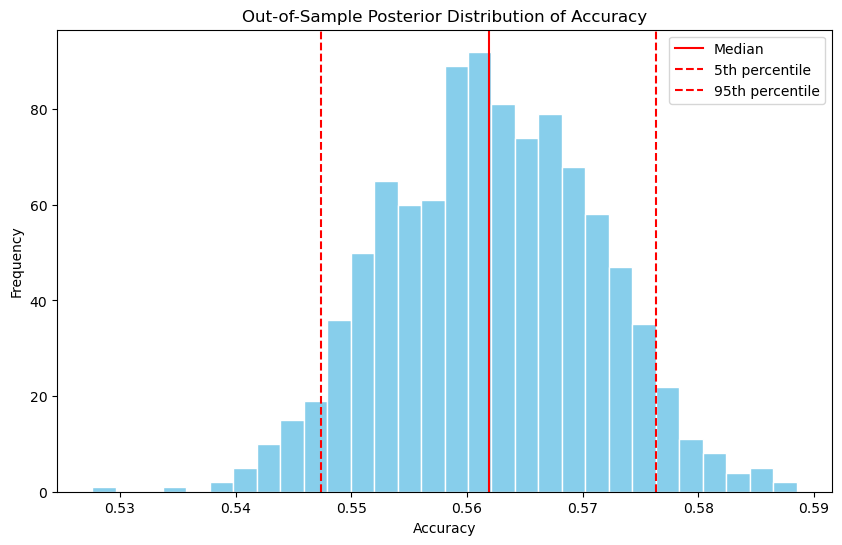

In [33]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

In [ ]:
# `Generalisation ROC Curve` and corresponding AUC

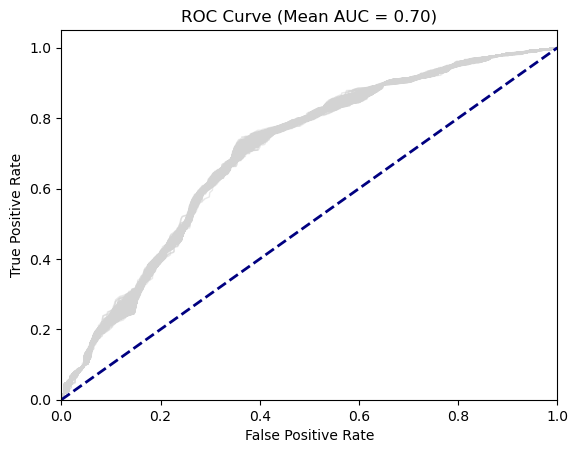

In [34]:
# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

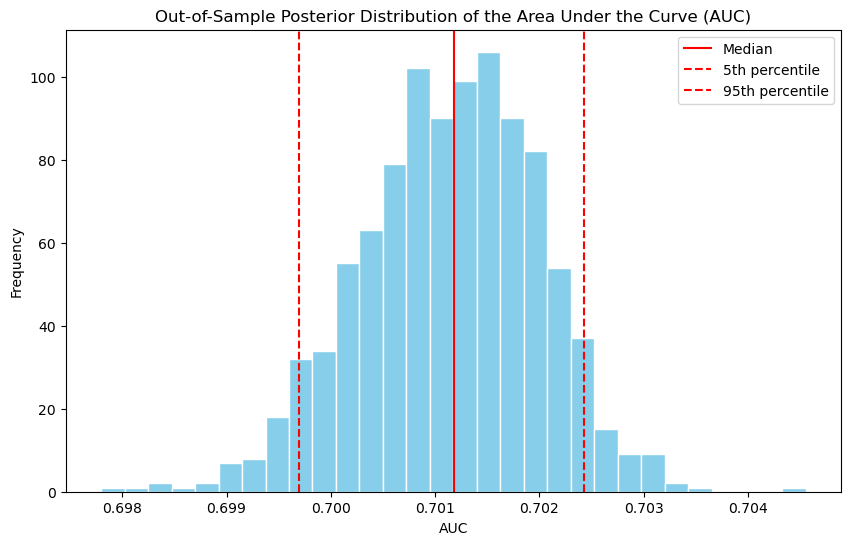

In [35]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(aucs), color='red', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

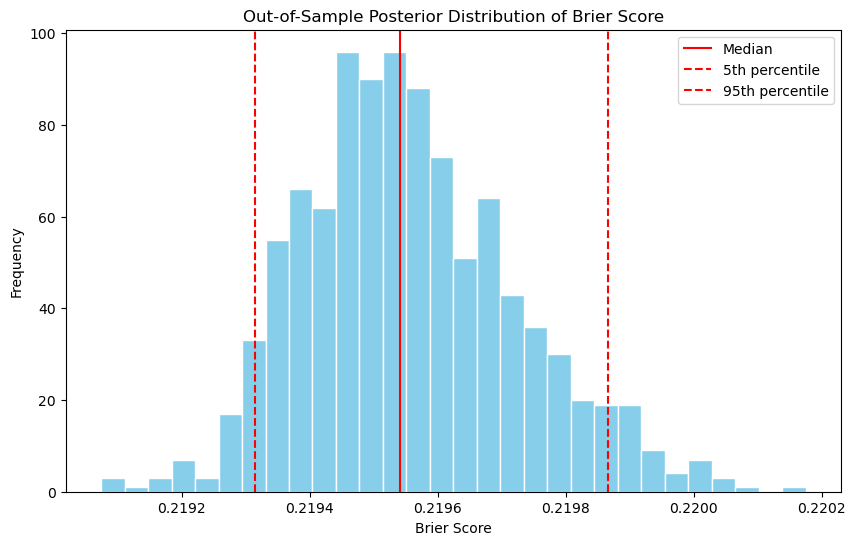

In [36]:
# Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(briers), color='red', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()